In [50]:
import numpy as np
import struct
import ctypes as ct
import matplotlib.pylab as plt

MAGIC=b'VCA DATA\x01\x00\x00U' #This sequence is the beginning of each file
MAGIC_SIZE=12
DEBUG=False

class DektakItem:
    
    def __init__(self, name=None, data_type=None, data=None):
        self.name=name
        self.data_type=data_type
        self.data=data

class DektakLoad:
    data_types=dict({'DEKTAK_MATRIX'       : 0x00, # Too lazy to assign an actual type id?
                    'DEKTAK_BOOLEAN'      : 0x01, # Takes value 0 and 1 */
                    'DEKTAK_SINT32'       : 0x06,
                    'DEKTAK_UINT32'       : 0x07,
                    'DEKTAK_SINT64'       : 0x0a,
                    'DEKTAK_UINT64'       : 0x0b,
                    'DEKTAK_FLOAT'        : 0x0c, # Single precision float */
                    'DEKTAK_DOUBLE'       : 0x0d, # Double precision float */
                    'DEKTAK_TYPE_ID'      : 0x0e, # Compound type holding some kind of type id */
                    'DEKTAK_STRING'       : 0x12, # Free-form string value */
                    'DEKTAK_QUANTITY'     : 0x13, # Value with units (compound type) */
                    'DEKTAK_TIME_STAMP'   : 0x15, # Datetime (string/9-byte binary) */
                    'DEKTAK_UNITS'        : 0x18, # Units (compound type) */
                    'DEKTAK_DOUBLE_ARRAY' : 0x40, # Raw data array, in XML Base64-encoded */
                    'DEKTAK_STRING_LIST'  : 0x42, # List of Str */
                    'DEKTAK_ANON_MATRIX'  : 0x45, # Like DEKTAK_MATRIX, but with no name. */
                    'DEKTAK_RAW_DATA'     : 0x46, # Parent/wrapper tag of raw data */
                    'DEKTAK_RAW_DATA_2D'  : 0x47, # Parent/wrapper tag of raw data */
                    'DEKTAK_POS_RAW_DATA' : 0x7c, # Base64-encoded positions, not sure how
                                                  # it differs from 64 */
                    'DEKTAK_CONTAINER'    : 0x7d, # General nested data structure */
                    'DEKTAK_TERMINATOR'   : 0x7f # Always the last item.
                                                   #Usually a couple of 0xff bytes inside. */
                                                   })
    
    def __init__(self,filename):
        self.filename=filename
        self.items=[]
        self.reading_2D=False
        self.reading_1D=False
        self.terminator=False
        self.current_count=0
        with open(self.filename, 'rb') as f:
            f.seek(0,2)
            self.eof=f.tell()
            f.seek(0,0)
        self.read()
    
    def read_varlen(self, f):
        length=int.from_bytes(f.read(1),"big")
        if length==1:
            return int.from_bytes(f.read(1),"big")
        elif length==2:
            return int.from_bytes(f.read(2),"big")
        elif length==4:
            return int.from_bytes(f.read(4),"big")
        else:
            print('The varlength format was not respected')
            return -1
    
    def read_structured(self, item, f):
        self.read_varlen(f)
        item.data=dict()
        item.data['items']=[]
        last_item=self.read_item(f)
        while(not self.terminator and last_item is not None):
            item.data['items'].append(last_item)
            last_item=self.read_item(f)
        self.terminator=False
        return item
    
    def read_name(self, f):
        data=f.read(4)
        length=struct.unpack('i',data)[0]
        return f.read(length).decode()
            

    
    def read_item(self, f):
        if f.tell()==self.eof:
            return None
        
        
        item=DektakItem()
        item.name=self.read_name(f)
        datatype=f.read(1)
        if DEBUG:
            print('the datatype of this item is: {:}'.format(datatype))
        item.data_type=int.from_bytes(datatype, "big")
        if item.data_type==DektakLoad.data_types['DEKTAK_BOOLEAN']:
            item.data=f.read(1)
        elif item.data_type==DektakLoad.data_types['DEKTAK_SINT32']:
            item.data=struct.unpack('I',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_UINT32']:
            item.data=struct.unpack('I',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_SINT64']:
            data=f.read(8)
            item.data=struct.unpack('Q',data)[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_UINT64']:
            item.data=struct.unpack('Q',f.read(8))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_FLOAT']:
            item.data=struct.unpack('f',f.read(4))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_DOUBLE']:
            item.data=struct.unpack('d',f.read(8))[0]
        elif item.data_type==DektakLoad.data_types['DEKTAK_TIME_STAMP']:
            item.data=f.read(9)
        elif item.data_type==DektakLoad.data_types['DEKTAK_STRING']:
            length=self.read_varlen(f)
            item.data=f.read(length).decode()
        elif item.data_type==DektakLoad.data_types['DEKTAK_STRING_LIST']:
            item.data=dict()
            item.data['datatype']=self.read_name(f)
            length=self.read_varlen(f)
            item.data['strings']=[self.read_name(f)]
        elif item.data_type==DektakLoad.data_types['DEKTAK_DOUBLE_ARRAY']:
            item.data=dict()
            item.data['datatype']=self.read_name(f)
            f.read(8)
            item.data['data']=np.frombuffer(f.read(self.current_count*8),
                     dtype=float)
        elif item.data_type==DektakLoad.data_types['DEKTAK_UNITS']:
            item.data=dict()
            item.data['length']=self.read_varlen(f)
            item.data['name']=self.read_name(f)
            item.data['symbol']=self.read_name(f)
            item.data['value']=struct.unpack('d',f.read(8))[0]
            f.read(12)
        elif item.data_type==DektakLoad.data_types['DEKTAK_QUANTITY']:
            item.data=dict()
            item.data['length']=self.read_varlen(f)
            item.data['value']=struct.unpack('d',f.read(8))[0]
            item.data['name']=self.read_name(f)
            item.data['symbol']=self.read_name(f)
            if len(item.data['name'])>0:
                f.read(20)
            else:
                f.read(16)
        elif item.data_type==DektakLoad.data_types['DEKTAK_TERMINATOR']:
            self.reading_2D=False
            self.reading_1D=False
            self.terminator=True
            item.data=f.read(2)
        elif item.data_type==DektakLoad.data_types['DEKTAK_TYPE_ID']:
            item.data=dict()
            item.data['name']=self.read_name(f)
            length=self.read_varlen(f)
            item.data['value']=int.from_bytes(f.read(length), 'little')
        elif item.data_type==DektakLoad.data_types['DEKTAK_POS_RAW_DATA']:
            if self.reading_2D:
                item.data=dict()
                item.data['name']=self.read_name(f)
                item.data['length']=self.read_varlen(f)
                item.data['value_x']=struct.unpack('d',f.read(8))[0]
                item.data['unit_name_x']=self.read_name(f)
                item.data['unit_symbol_x']=self.read_name(f)
                item.data['divisor_x']=struct.unpack('d',f.read(8))[0]
                f.read(12)
                item.data['value_y']=struct.unpack('d',f.read(8))[0]
                item.data['unit_name_y']=self.read_name(f)
                item.data['unit_symbol_y']=self.read_name(f)
                item.data['divisor_y']=struct.unpack('d',f.read(8))[0]
                f.read(12)
            elif self.reading_1D:
                item.data=dict()
                item.data['name']=self.read_name(f)
                item.data['length']=self.read_varlen(f)
                item.data['unit_name']=self.read_name(f)
                item.data['unit_symbol']=self.read_name(f)
                item.data['divisor']=struct.unpack('d',f.read(8))[0]
                f.read(12)
                item.data['count']=struct.unpack('Q',f.read(8))[0]
                self.current_count=item.data['count']
                N=item.data['length']
                N=item.data['count']
                item.data['data']=np.frombuffer(f.read(N*8), dtype=float)
                
        elif item.data_type==DektakLoad.data_types['DEKTAK_ANON_MATRIX']:
            item.data=dict()
            item.data['name']=self.read_name(f)
            item.data['size']=self.read_varlen(f)
            item.data['yres']=struct.unpack('I',f.read(4))[0]
            item.data['xres']=struct.unpack('I',f.read(4))[0]
            if item.data['size']<2*ct.sizeof(ct.c_uint32):
                print('PROBLEM')
            item.data['size']-=2*ct.sizeof(ct.c_uint32)
            N=item.data['xres']*item.data['yres']
            data=f.read(4*N)
            item.data['data']=np.reshape(np.frombuffer(data,
                     dtype="float32"), (item.data['yres'],
                                    item.data['xres']))
            
            
        elif item.data_type==DektakLoad.data_types['DEKTAK_MATRIX']:
            item.data=dict()
            item.data['name']=f.read(4)
            item.data['size']=self.read_varlen(f)
            item.data['xres']=struct.unpack('I',f.read(4))[0]
            item.data['yres']=struct.unpack('I',f.read(4))[0]
            if item.data['size']<2*ct.sizeof(ct.c_uint32):
                print('PROBLEM')
            item.data['size']-=2*ct.sizeof(ct.c_uint32)
        elif item.data_type==DektakLoad.data_types['DEKTAK_CONTAINER']:
            if item.name=='1D_Data':
                self.reading_1D=True
            elif item.name=='2D_Data':
                self.reading_2D=True
            item=self.read_structured(item, f)
        elif item.data_type==DektakLoad.data_types['DEKTAK_RAW_DATA']:
            item=self.read_structured(item, f)
        elif item.data_type==DektakLoad.data_types['DEKTAK_RAW_DATA_2D']:
            item=self.read_structured(item, f)
        else:
            print('unknown data_type')
            print(f.read(100))
            print(item.data_type)
        if DEBUG:
            print('{:},{:},{:}===>>>>{:} ; {:}'.format(item.data_type,
              f.tell(), datatype, item.name, item.data))
        return item
            
        
    def read(self):
        with open(self.filename, 'rb') as f:
            while(f.tell()!=MAGIC_SIZE):
                f.read(1)
            while(len(self.items)<10):
                item=self.read_item(f)
                self.items.append(item)
    
    def get_data_1D(self):
        x,y,scale, divisor=None, None, None, None
        for item in self.items:
            if item is not None:
                if item.name=='1D_Data':
                    break
        subitem=None
        for k in item.data['items']:
            if k.name=='Raw':
                subitem=k
                break
        if subitem is not None:
            for k in subitem.data['items']:
                if k.name=='PositionFunction':
                    x=k.data['data']
                    divisor=k.data['divisor']
                elif k.name=='Array':
                    y=k.data['data']
                elif k.name=='DataScale':
                    scale=k.data['value']
            return x/divisor, y*scale/divisor
        else:
            return None, None
    
    def get_data_2D(self, plot=True):
        for item in self.items:
            if item is not None:
                if item.name=='2D_Data':
                    break
        subitem=None
        for k in item.data['items']:
            if k.name=='Raw':
                subitem=k
                break
        if subitem is not None:
            divisor=1
            for mat in subitem.data['items']:
                if mat.name=='Matrix':
                    break
            for scale in subitem.data['items']:
                if scale.name=='DataScale':
                    if scale.data['name']=='Micrometer':
                        divisor=1e6
                    break
            for dim1 in subitem.data['items']:
                if dim1.name=='Dimension1Extent':
                    break
            for dim2 in subitem.data['items']:
                if dim2.name=='Dimension2Extent':
                    break
            for subsubitem in subitem.data['items']:
                if subsubitem.name=='PositionFunction':
                    symbol_x, symbol_y=(subsubitem.data['unit_symbol_x'],
                                        subsubitem.data['unit_symbol_y'])
                    break
            if plot:
                print("scale %.2f "%scale.data['value'])
                teste = mat.data['data']
                plt.imshow(mat.data['data']*scale.data['value'],
                           extent=[0,dim2.data['value'],
                                   0,dim1.data['value']])
                plt.xlabel(symbol_x)
                plt.ylabel(symbol_y)
            zs=mat.data['data']*scale.data['value']/divisor
            xs=np.linspace(0, dim1.data['value'],
                           np.shape(mat.data['data'])[1])
            print("xs max %.2f "%dim1.data['value'])
            ys=np.linspace(0, dim2.data['value'],
                           np.shape(mat.data['data'])[0])
            print("ys max %.2f "%dim2.data['value'])
            return (xs, ys, zs, teste)
        else:
            return None, None, None, None
    
    def get_metadata(self):
        for item in self.items:
            if item is not None:
                if item.name=='MetaData':
                    break
        res=dict()
        for k in item.data['items']:
            if not isinstance(k.data, dict):
                res[k.name]=k.data
            else:
                res[k.name]=dict()
                for child in k.data['items']:
                    res[k.name][child.name]=child.data
        return res

scale 0.01 
xs max 1199.50 
ys max 2990.00 


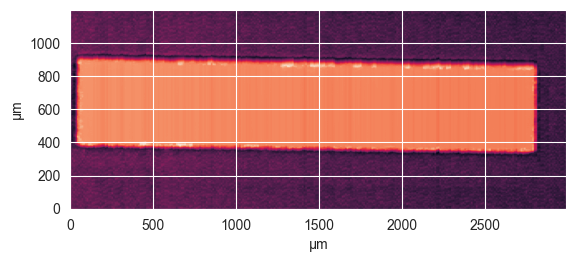

In [206]:
loader = DektakLoad('T1B\T1B_0graus_Negativo.OPDx')
X,y,z,teste = loader.get_data_2D()


In [207]:
import pandas as pd
import seaborn as sns    

div = 100
x = 150

sns.set_style('darkgrid')
sns.set_palette('tab10')


17.414639


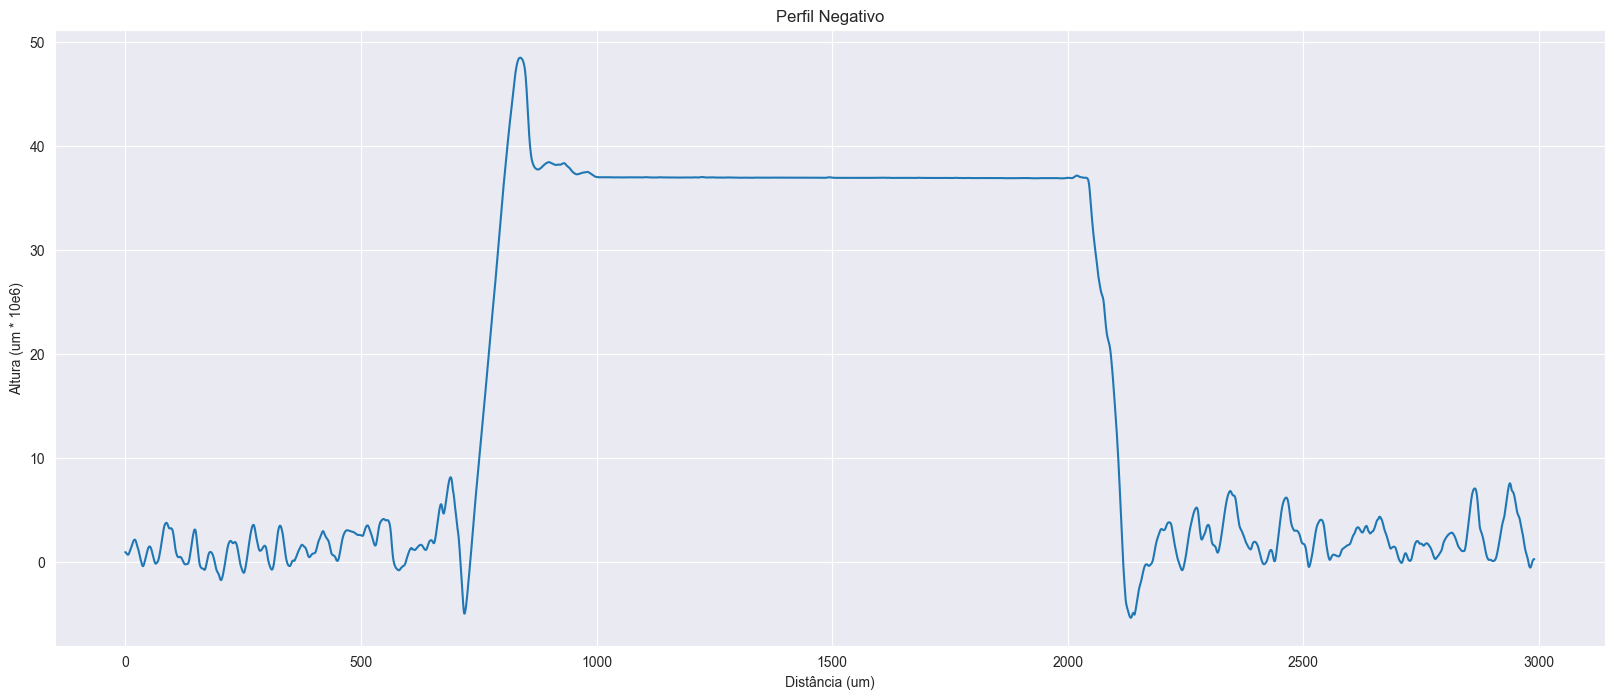

In [208]:
aux = pd.Series()
for i in range(len(y)):
    aux[i] = ((z[i][x]*1000000))
print(aux.mean())
if aux.mean() > 0:
    Perfil = "Negativo"
else:
    Perfil = "Positivo"

ax = sns.lineplot(y= aux, x = y)
ax.figure.set_size_inches(20,8)
ax.set_title("Perfil %s"%Perfil)
ax.set(xlabel = "Distância (um)", ylabel = "Altura (um * 10e6)")


"""Exibir um ponto aleatório na curva


rng = np.random.default_rng()
s = rng.integers(low=0, high=4801, size=1)
print(s)
px = aux[s[0]]
py = y[s[0]]

print(px,py)
plt.scatter(x=py, y = px ,c='r', s = 15)
"""
plt.show()

4701


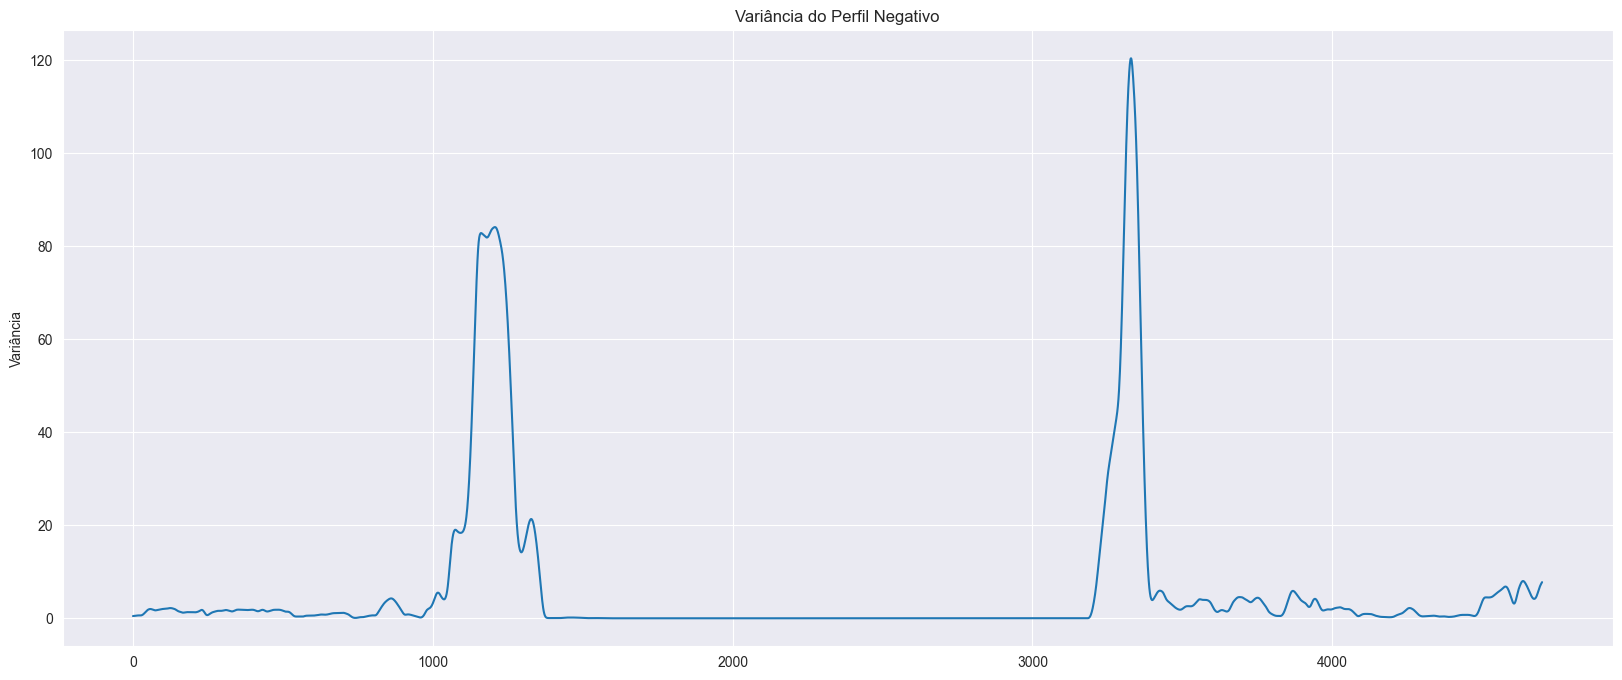

In [209]:
alpha = pd.Series()
aux_var = pd.Series()

for i in range(len(aux)-div):
    for j in range(div):
        alpha[j] = aux[i+j]
    aux_var[i] = alpha.var()

print(len(aux_var))
ax = sns.lineplot(aux_var)
ax.figure.set_size_inches(20,8)
ax.set_title("Variância do Perfil %s"%Perfil)
ax.set(ylabel = "Variância")
plt.show()

In [210]:
indices_criticos = []


for i in range(len(aux_var)):
    if i <= 2 or i >= (len(aux_var) - 3):
        pass
    else:
        s = (aux_var[i+3] - aux_var[i-3])
        if (s > 0.5) or (s < -0.5):
            indices_criticos.append(i)
            #indices_criticos_positivo[i] = i
#indices_criticos_positivo.reset_index(inplace=True, drop = True)
print(indices_criticos)

[236, 237, 238, 239, 240, 241, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 

819


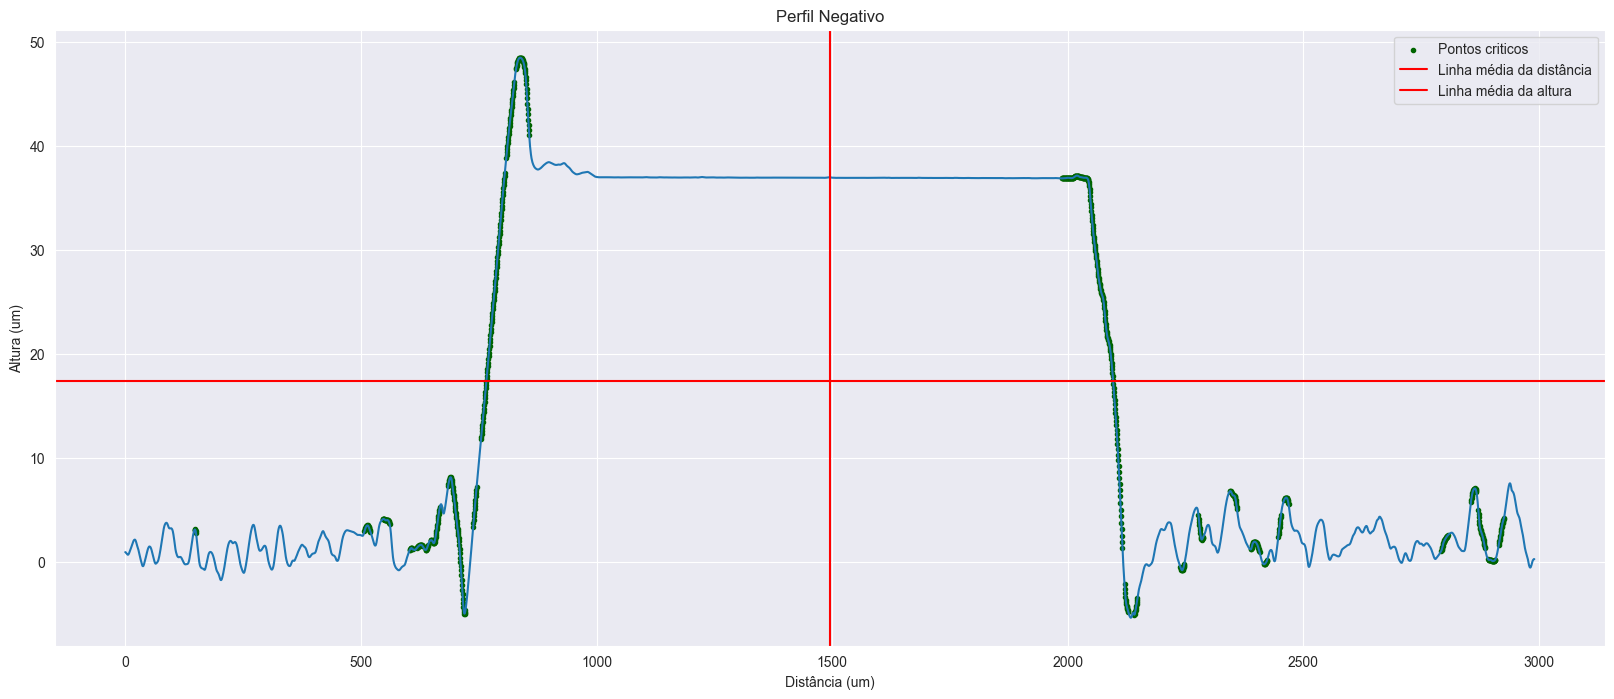

In [211]:
print(len(indices_criticos))

ax = sns.lineplot(y = aux, x = y)
ax.figure.set_size_inches(20,8)
ax.set_title("Perfil %s"%Perfil)
ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")

for i in range(len(indices_criticos)):
    #plt.axvline(y[indices_criticos[i]], color = 'lightgreen')
    if i == (len(indices_criticos) - 1):
        plt.scatter(x=y[indices_criticos[i]], y = aux[indices_criticos[i]] ,c='darkgreen', s = 9, label = 'Pontos criticos')
    else:    
        plt.scatter(x=y[indices_criticos[i]], y = aux[indices_criticos[i]] ,c='darkgreen', s = 9)
plt.axvline(y.mean(), color = 'r', label = "Linha média da distância")
plt.axhline(aux.mean(), color = 'r', label = "Linha média da altura")
plt.legend(loc = 'upper right')
plt.show()

In [212]:
def AchaMenor(beta,alcance):
    m=0
    indice_menor = 0
    
    excluidos = pd.Series()
    for i in range(alcance):
            if beta[i] > aux.mean():
                excluidos[i] = beta[i]
                beta.pop(i)
    beta.reset_index(drop = True, inplace = True)
    
    
    #print(round(len(beta)/3))
    while m < len(beta)/3:
        if beta[m] < beta[indice_menor]:
            indice_menor = m
            #print("indice menor = %d"%indice_menor) 
        else:
            indice_menor = indice_menor
            #print("indice menor = %d"%indice_menor) 
        m = m + 1

    return (indice_menor + len(excluidos))

In [213]:
if Perfil == 'Negativo':
   alcance_maiores = []
   alcance_menores = []


   for i in range(len(indices_criticos)):
      if y[indices_criticos[i]] > int(y.mean()):
         alcance_maiores.append(i)
      else:
         alcance_menores.append(i)
      

   """

   if alcance <= 1:
      alcance = 3
   print(alcance)

   """


   beta = pd.Series()
   for i in range(len(alcance_maiores)):
      beta[i] = aux[indices_criticos[alcance_maiores[i]]]
   menor = AchaMenor(beta,len(alcance_maiores))

   secao5_comeca = indices_criticos[alcance_maiores[menor]]
   secao4_termina = indices_criticos[alcance_maiores[menor]] - 1


   beta = pd.Series()
   for i in range(len(alcance_menores)):
      beta[i] = aux[indices_criticos[alcance_menores[i]]]

   menor = AchaMenor(beta,len(alcance_menores))

   secao1_termina = indices_criticos[alcance_menores[menor]] 
   secao2_comeca = indices_criticos[alcance_menores[menor]] + 1

   a = alcance_maiores[0]

   secao1_comeca = 0
   secao2_termina = indices_criticos[alcance_menores[-1]]
   secao3_comeca = indices_criticos[alcance_menores[-1]] + 1
   secao3_termina = indices_criticos[alcance_maiores[0]] - 1
   secao4_comeca = indices_criticos[a]
   secao5_termina = len(y)-1

   print(a ,secao4_começa, y[secao4_comeca], y[secao4_termina])

if Perfil == 'Positivo':
   print("nsahfuidsafsd")
   alcance_maiores = []
   alcance_menores = []

   for i in range(len(indices_criticos)):
      if y[indices_criticos[i]] > int(y.mean()):
         alcance_maiores.append(i)
      else:
         alcance_menores.append(i)

   beta = pd.Series()
   for i in range(len(alcance_maiores)):
      beta[i] = aux[indices_criticos[i]]
   print(beta)
   menor = AchaMenor(beta,len(alcance_maiores))
   print(menor)
   secao2_termina = indices_criticos[menor] - 1
   secao3_comeca = indices_criticos[menor]

   beta = pd.Series()
   for i in range(len(alcance_menores)):
      beta[i] = aux[indices_criticos[-1*(i+1)]]

   menor = AchaMenor(beta,len(alcance_menores))

   secao3_termina = indices_criticos[-1*menor] - 1
   secao4_comeca = indices_criticos[-1*menor]

   secao1_comeca = 0
   secao1_termina = indices_criticos[0]- 1
   secao2_comeca = indices_criticos[0]
   secao4_termina = indices_criticos[-1] - 1
   secao5_comeca = indices_criticos[-1] 
   secao5_termina = len(y)-1

353 2796 1987.7270833333334 2140.9645833333334


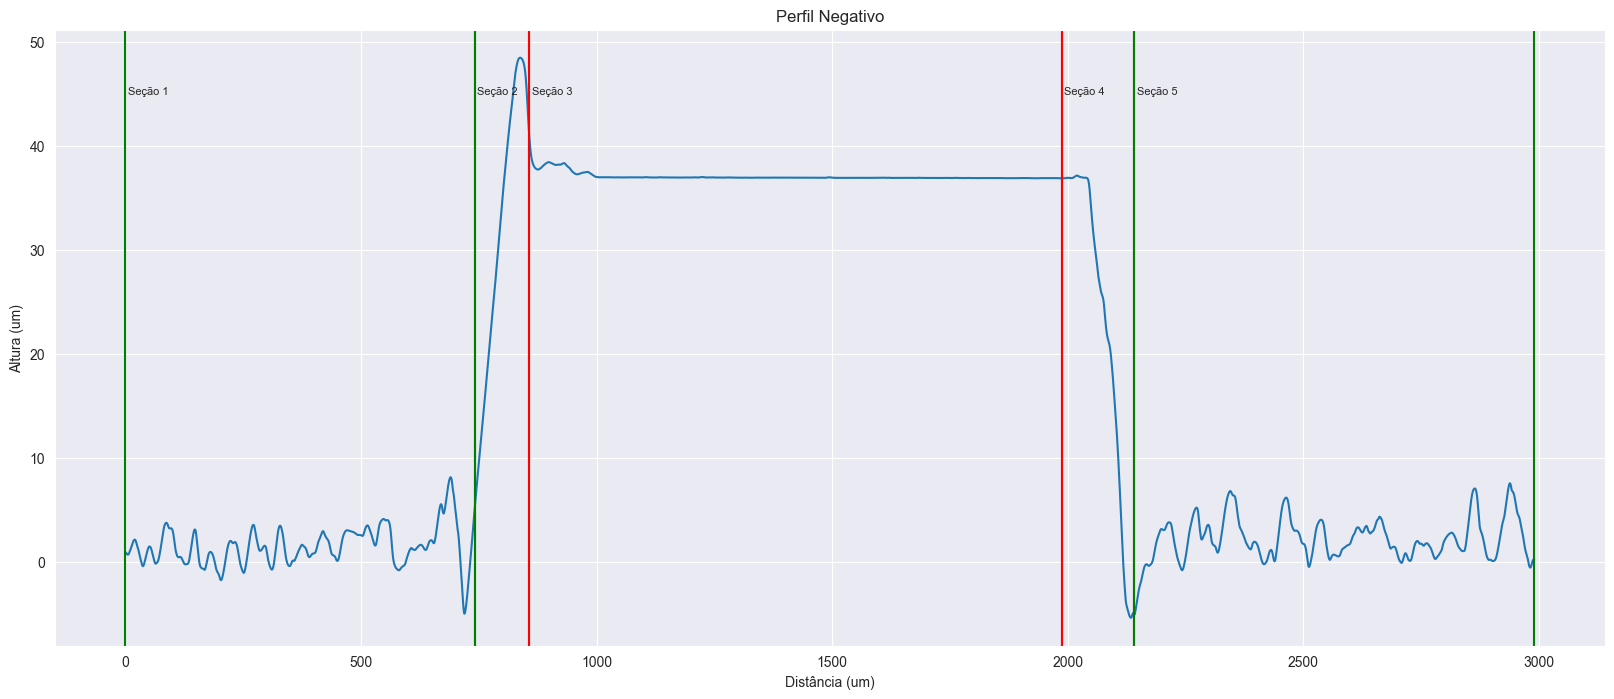

In [214]:
if Perfil == 'Positivo':
    ax = sns.lineplot(y = aux, x = y)

    ax.figure.set_size_inches(20,8)
    ax.set_title("Perfil %s"%Perfil)
    ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")


    plt.axvline(y[secao1_comeca], color = 'r')
    plt.axvline(y[secao1_termina], color = 'r')
    plt.axvline(y[secao2_comeca], color = 'r')
    plt.axvline(y[secao2_termina], color = 'darkgreen')
    plt.axvline(y[secao3_comeca], color = 'darkgreen')
    plt.axvline(y[secao3_termina], color = 'darkgreen')
    plt.axvline(y[secao4_comeca], color = 'darkgreen')
    plt.axvline(y[secao4_termina], color = 'r')
    plt.axvline(y[secao5_comeca], color = 'r')
    plt.axvline(y[secao5_termina], color = 'r')

    plt.text(x = y[secao1_comeca]+5, y = (aux[0]+5), s="Seção 1", fontsize = '8')
    plt.text(x = y[secao2_comeca]+5, y = (aux[0]+5), s="Seção 2", fontsize = '8')
    plt.text(x = y[secao3_comeca]+5, y = (aux[0]+5), s="Seção 3", fontsize = '8')
    plt.text(x = y[secao4_comeca]+5, y = (aux[0]+5), s="Seção 4", fontsize = '8')
    plt.text(x = y[secao5_comeca]+5, y = (aux[0]+5), s="Seção 5", fontsize = '8')
    plt.show()

if Perfil == 'Negativo':
    ax = sns.lineplot(y = aux, x = y)

    ax.figure.set_size_inches(20,8)
    ax.set_title("Perfil %s"%Perfil)
    ax.set(xlabel = "Distância (um)", ylabel = "Altura (um)")


    plt.axvline(y[secao1_comeca], color = 'g')
    plt.axvline(y[secao1_termina], color = 'g')
    plt.axvline(y[secao2_comeca], color = 'g')
    plt.axvline(y[secao2_termina], color = 'r')
    plt.axvline(y[secao3_comeca], color = 'r')
    plt.axvline(y[secao3_termina], color = 'r')
    plt.axvline(y[secao4_comeca], color = 'r')
    plt.axvline(y[secao4_termina], color = 'r')
    plt.axvline(y[secao5_comeca], color = 'g')
    plt.axvline(y[secao5_termina], color = 'g')

    plt.text(x = y[secao1_comeca]+5, y = (aux[0]+44), s="Seção 1", fontsize = '8')
    plt.text(x = y[secao2_comeca]+5, y = (aux[0]+44), s="Seção 2", fontsize = '8')
    plt.text(x = y[secao3_comeca]+5, y = (aux[0]+44), s="Seção 3", fontsize = '8')
    plt.text(x = y[secao4_comeca]+5, y = (aux[0]+44), s="Seção 4", fontsize = '8')
    plt.text(x = y[secao5_comeca]+5, y = (aux[0]+44), s="Seção 5", fontsize = '8')
    plt.show()

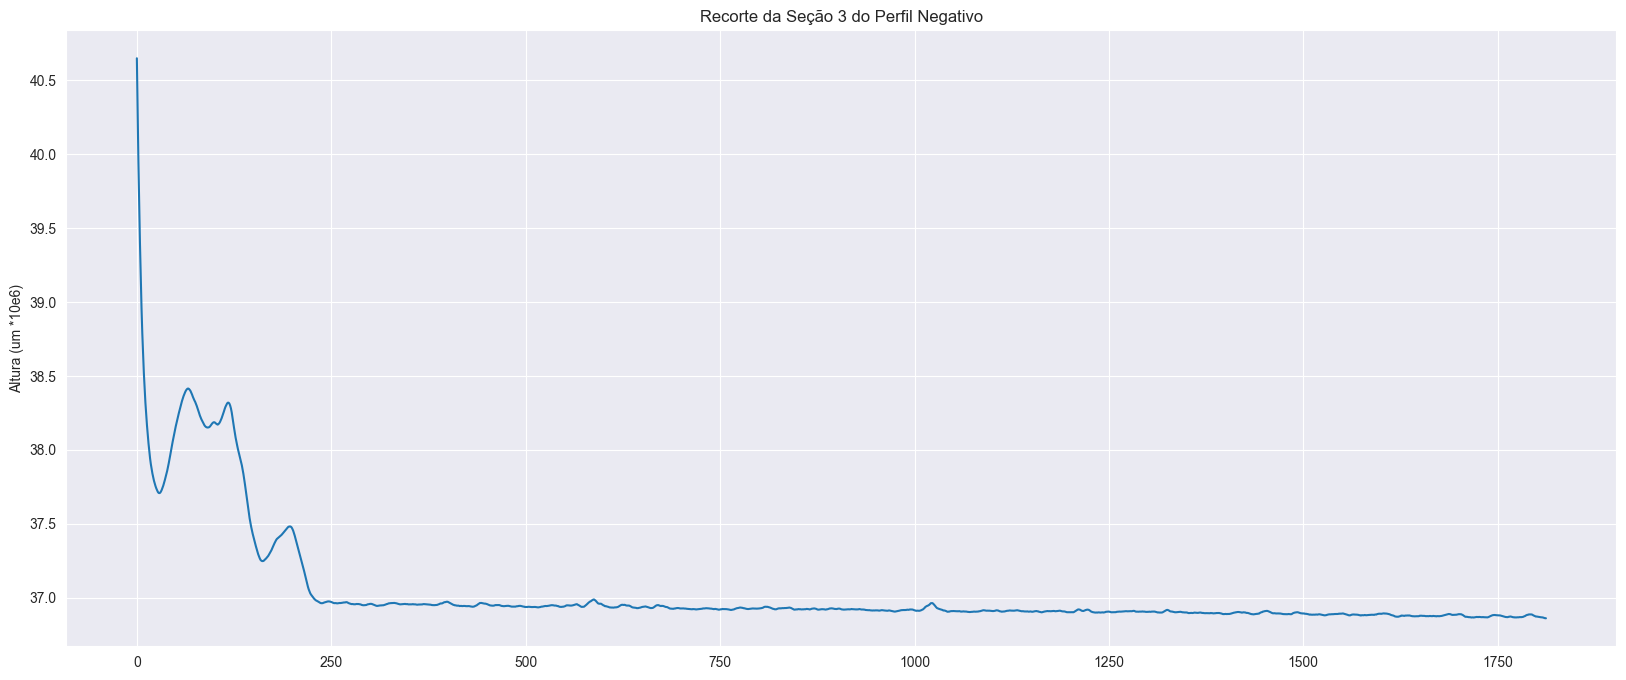

In [218]:
secao3 = pd.Series()

if Perfil == 'Negativo':
    alcance = secao3_termina - secao3_comeca


    for i in range(alcance):
        secao3[i] = aux[i + secao3_comeca]
    a = secao3

ax = sns.lineplot(a)

ax.figure.set_size_inches(20,8)
ax.set_title("Recorte da Seção 3 do Perfil %s"%Perfil)
ax.set(ylabel = "Altura (um *10e6)")

plt.show()


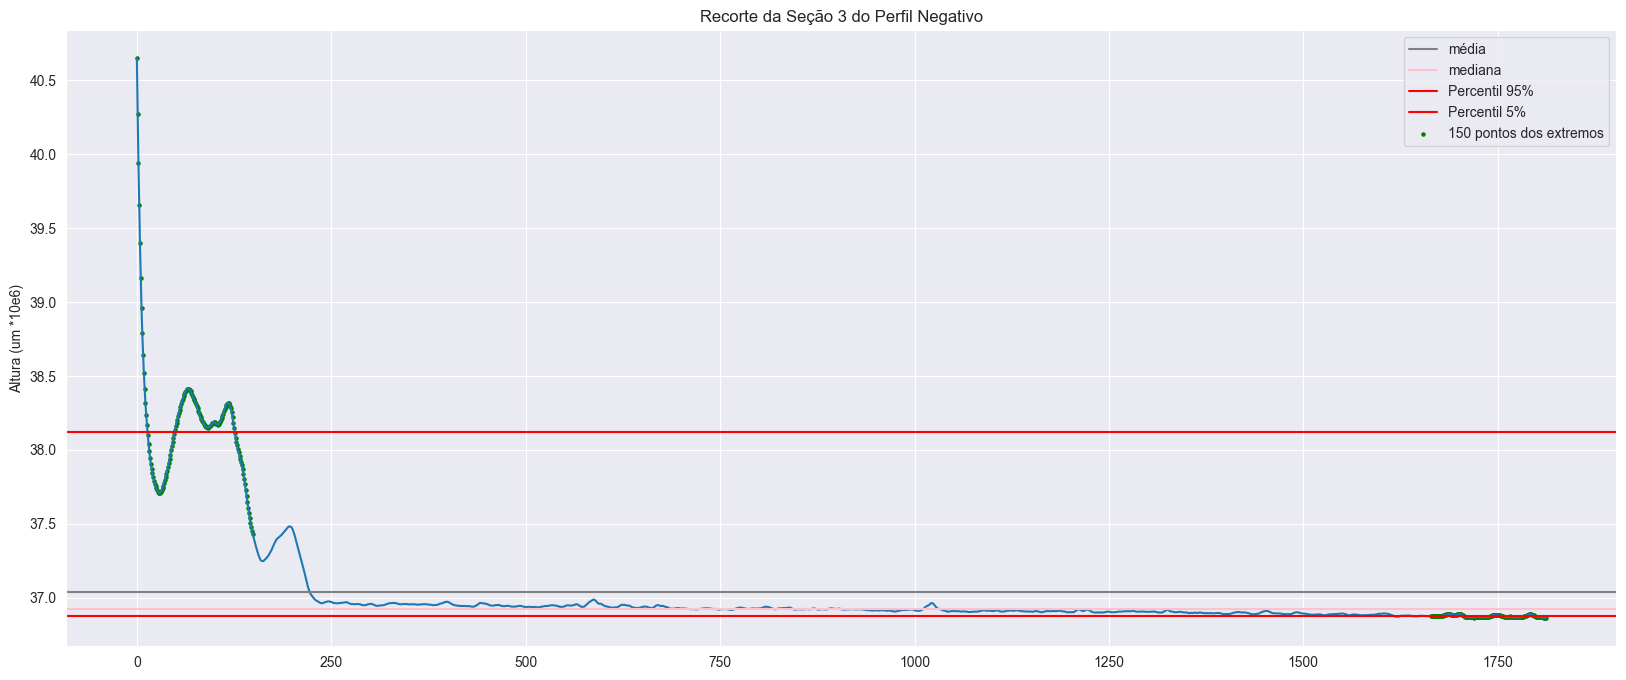

In [219]:
ax = sns.lineplot(secao3)

ax.figure.set_size_inches(20,8)
ax.set_title("Recorte da Seção 3 do Perfil %s"%Perfil)
ax.set(ylabel = "Altura (um *10e6)")

plt.plt.axhline(y = secao3.mean(),c='gray', label = "média")
plt.plt.axhline(y = secao3.median(),c='pink', label = "mediana")
plt.axhline(y = secao3.quantile(q = 0.95),c='r', label = "Percentil 95%")
plt.axhline(y = secao3.quantile(q = 0.05),c='r', label = "Percentil 5%")
for i in range(150):
    if i == 149:
        plt.scatter(y = secao3[i], x = i, c = 'g', s=5, label = "150 pontos dos extremos")
    else:
        plt.scatter(y = secao3[i], x = i, c = 'g', s=5)
        plt.scatter(y = secao3[len(secao3)-1 - i], x = (len(secao3)-1 - i), c = 'g', s=5)

plt.legend(loc = 'upper right')

plt.show()

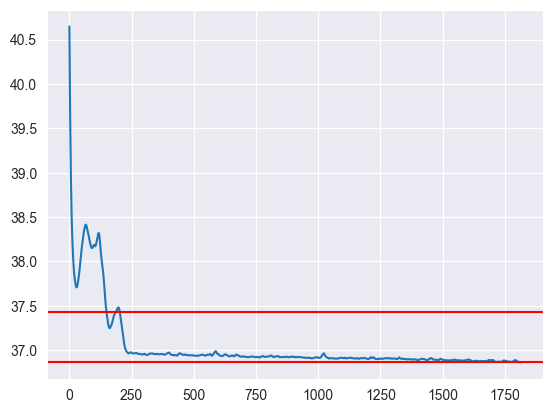

In [217]:
lista_dir = pd.Series()
lista_esq = pd.Series()
for i in range(150):
    lista_esq[i] = secao3[i]
    lista_dir[i] = secao3[len(secao3)-1 - i]
#print(lista_esq)
minimo_esq = lista_esq.min()
minimo_dir = lista_dir.min()
#minimo_dir = AchaMenor(lista_dir, len(lista_dir))

ax = sns.lineplot(secao3)
plt.axhline(minimo_esq, color = 'r')
plt.axhline(minimo_dir, color = 'r')
plt.show()